<a href="https://colab.research.google.com/github/jpatrickweller/Data_Challenges/blob/main/SARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
# bring in the usual suspects
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
register_matplotlib_converters()


### Catfish Sales!!

In [206]:
def parser(s):
    return dt.datetime.strptime(s, '%Y-%m-%d')

In [207]:
# read in data
url = 'https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/catfish.csv'
s = pd.read_csv(url, squeeze=True, index_col=0, parse_dates=False, date_parser=parser)

s

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Name: Total, Length: 324, dtype: int64

In [208]:
# Infer frequency of the index
s = s.asfreq(pd.infer_freq(s.index))
s

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 324, dtype: int64

In [209]:
# subselecting to train on 4 years
start_date = dt.datetime(1996,1,1)
end_date = dt.datetime(2000,1,1)
catfish_s = s[start_date:end_date]

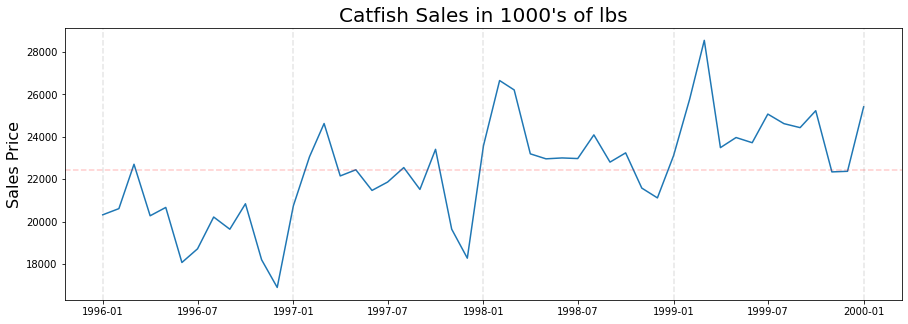

In [210]:
# Plot them sales!

def plot_ts(s):

    plt.figure(figsize=(15,5))
    plt.plot(s)
    plt.title("Catfish Sales in 1000's of lbs", fontsize=20)
    plt.ylabel('Sales Price', fontsize=16)
    for year in s.index.year.unique():
        plt.axvline(
            x=pd.to_datetime(str(year)+'-01-01'), 
            linestyle='--', 
            c='grey', 
            alpha=.2
        )
    plt.axhline(y=s.mean(), linestyle='--', color='r', alpha=.2)

    plt.show()

plot_ts(catfish_s)

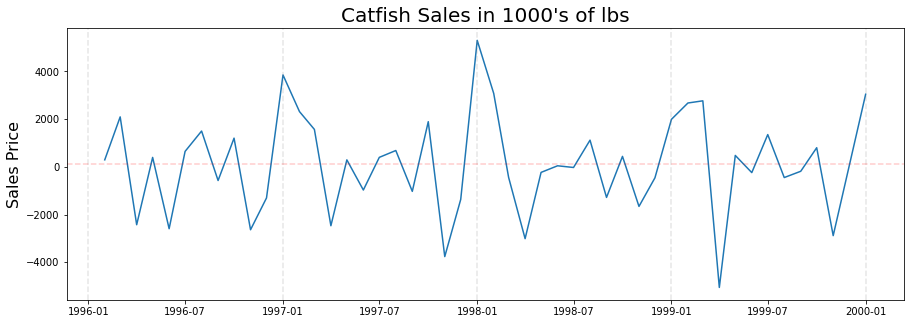

In [211]:
# Looks to be a bit of a trend over time. I'll use first diff to regress that out.
cf_first_diff = catfish_s.diff()[1:]

plot_ts(cf_first_diff)
# This looks better

Assess the ACF and PACF to inform the ARMA model.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


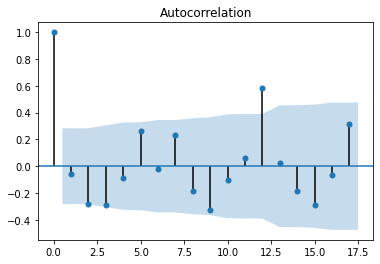

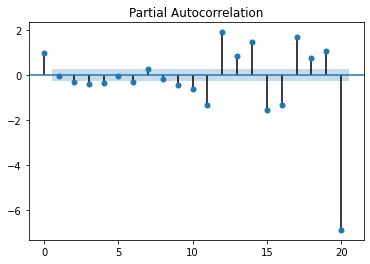

In [212]:
num_lags = 20

# Assessing vals
plot_acf(cf_first_diff)
plot_pacf(cf_first_diff,lags=num_lags)

# keeping vals to build model
acf_vals = acf(cf_first_diff)
pacf_vals = pacf(cf_first_diff)

In [213]:
# Based on the ACF, let's start with an MA(1) process
# Based on the PASF, let's start with an AR(4) process
# The PASF also showed seasonality (peak at 12), but holding off for now.

## Train / test split


In [214]:
train_end = dt.datetime(1999,7,1)
test_end = dt.datetime(2000,1,1)

train_data = cf_first_diff[:train_end]
test_data = cf_first_diff[train_end + dt.timedelta(days=1):test_end]

## Fit the model

In [215]:
# load the model
model = ARMA(train_data, order=(4,1))

# Fit the model
model_fit = model.fit()

# Assess the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                     ARMA(4, 1)   Log Likelihood                -371.167
Method:                       css-mle   S.D. of innovations           1623.533
Date:                Tue, 02 Mar 2021   AIC                            756.335
Time:                        02:19:56   BIC                            768.499
Sample:                    02-01-1996   HQIC                           760.793
                         - 07-01-1999                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         102.0560    127.048      0.803      0.427    -146.954     351.066
ar.L1.Total    -0.8971      0.150     -5.995      0.000      -1.190      -0.604
ar.L2.Total    -0.4967      0.162     -3.067      0.004      -0.814      -0.179
ar.L3.Total    -0.5849      0.156     -3.751      0.001      -0.890      -0.279
ar.L4.Total    -0.6008      0.130     -4.628      0.000      -0.855      -0.346
ma.L1.Total     0.7585      0.137      5.524      0.000       0.489       1.028
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9497           -0.5548j            1.0999           -0.4159
AR.2           -0.9497           +0.5548j            1.0999            0.4159
AR.3            0.4630           -1.0777j            1.1730           -0.1854
AR.4            0.4630           +1.0777j            1.1730            0.1854
MA.1           -1.3183           +0.0000j            1.3183            0.5000
-----------------------------------------------------------------------------
"""

In [230]:
def plot_predictions(observations, predictions):

    # Plot the time series and forecast
    plt.figure(figsize=(15,5))
    plt.title("Catfish Sales and Forecast", fontsize=20)
    plt.plot(observations, label="Observations")
    h = plt.plot(predictions, label="Predictions")
    plt.ylabel("Catfish sales in 1000s of lbs", fontsize=16)
    plt.legend(loc='best', fontsize=16)
    for year in observations.index.year.unique():
        x_val = pd.to_datetime(str(year)+'-01-01')
        plt.axvline(x=x_val, linestyle='--', color='k', alpha=.2)
    # plt.axhline(y=0, linestyle='--', color='r', alpha=.2)
    plt.show()

    # Residuals
    plt.figure(figsize=(15,5))
    residuals = observations[-len(predictions):] - predictions
    plt.plot(residuals)
    plt.axhline(y=0, linestyle='--', color='r', alpha=.8)
    plt.title('Residuals from fit', fontsize=20)
    plt.ylabel("Error", fontsize=16)
    plt.show()

    mse = (residuals.values**2).mean().round(2)
    mpe = round(np.mean(abs(residuals/observations[-len(predictions):])),4)
    print(f"Mean absolute percent error: {mpe}")
    print(f"Mean squared error = {mse}")


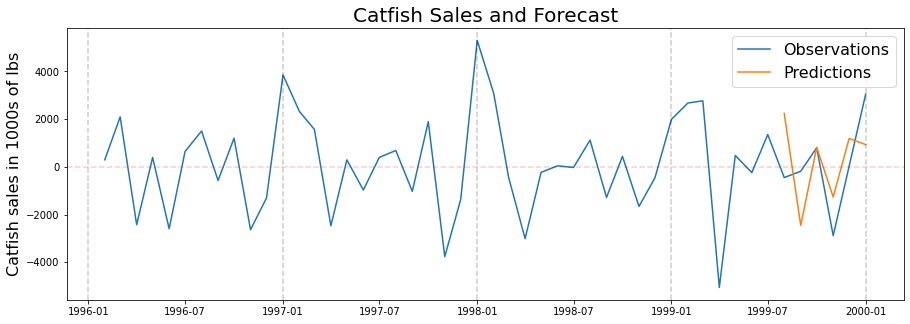

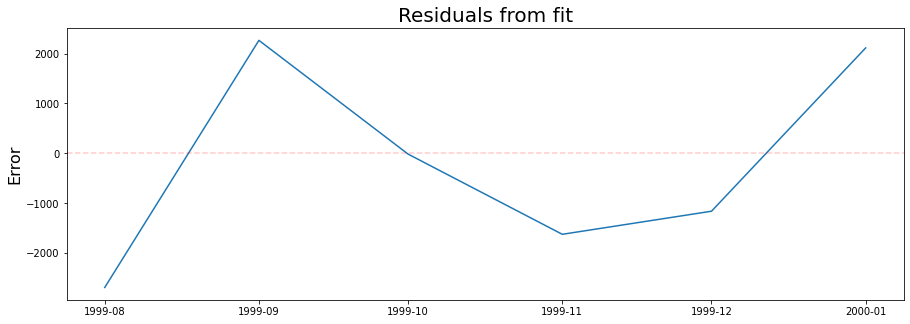

Mean absolute percent error: 10.1113
Mean squared error = 3464143.95


In [217]:
# Let's predict!
start_date = test_data.index[0]
end_date = test_data.index[-1]
predictions = model_fit.predict(start=start_date, end=end_date)

plot_predictions(cf_first_diff, predictions)

## SARIMA TIME!

In [225]:
# Additional import
from statsmodels.tsa.statespace.sarimax import SARIMAX

# I want to incorporate the de-trending into the sarima model, so I'm recutting
# the training and test data
train_data = catfish_s[:train_end]
test_data = catfish_s[train_end+dt.timedelta(days=1):test_end]

# Define and load the model
order = (0,1,0)
seasonal_order = (1, 0, 1, 12) # This last one is the frequency
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

# fit the model
start = time()
model_fit = model.fit()
end = time()
print(f"Total time to fit = {round(end-start,3)}s")

#Show a summary
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Total time to fit = 0.279s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 12)   Log Likelihood                -365.635
Date:                            Tue, 02 Mar 2021   AIC                            737.269
Time:                                    02:20:35   BIC                            742.482
Sample:                                01-01-1996   HQIC                           739.180
                                     - 07-01-1999                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.5187      0.197     -2.632      0.008      -0.905      -0.132
sigma2       1.78e+06    4.7e+05      3.791      0.000     8.6e+05     2.7e+06
===================================================================================
Ljung-Box (Q):                       55.29   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.05   Prob(JB):                         0.57
Heteroskedasticity (H):               0.81   Skew:                            -0.30
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

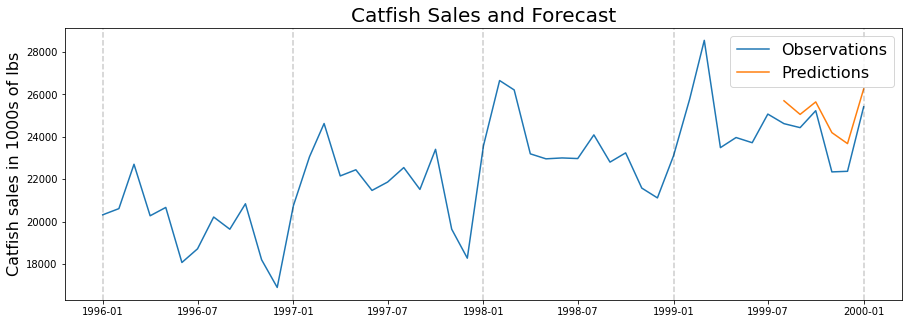

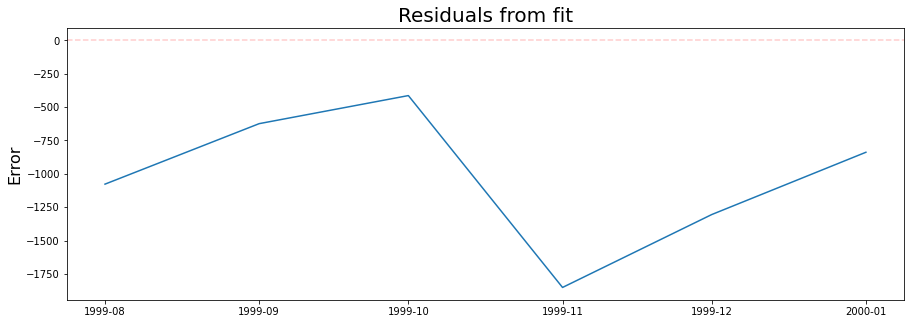

Mean absolute percent error: 0.0433
Mean squared error = 1259571.87


In [226]:
# Make predictions!
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

plot_predictions(catfish_s, predictions)

In [220]:
# Hmm systematically low. I'll try a rolling forecast

## Using Rolling Forecast Origin

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


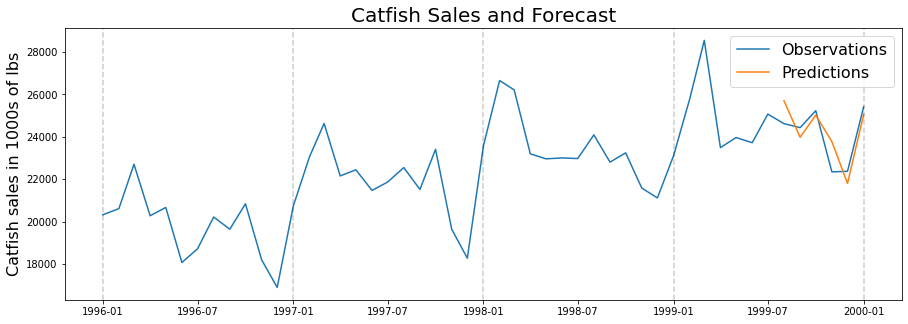

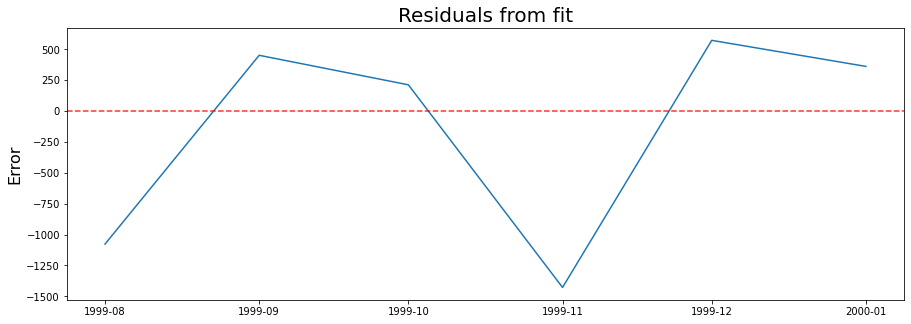

Mean absolute percent error: 0.0291
Mean squared error = 651359.83


In [231]:
rolling_predictions = test_data.copy()
for date in test_data.index:
    
    # Select all but the current date to train on
    train_data = catfish_s[:date-dt.timedelta(days=1)]

    # Load the model
    model= SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

    # Fit the model
    model_fit = model.fit()

    # Add new prediction to rolling preds
    rolling_predictions[date] = model_fit.forecast()

plot_predictions(catfish_s, rolling_predictions)

In [231]:
# Nice! Looks better!